In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [580]:
from fsd_path_planning.demo.streamlit_demo.common import get_cones_for_configuration
import numpy as np
import matplotlib.pyplot as plt
from fsd_path_planning.utils.math_utils import rotate, angle_from_2d_vector
from numpy import array, float64

In [625]:
# position, direction, cones = get_cones_for_configuration("Hairpin Extreme", do_shuffle=True)

# position = np.array([36, 30.0])
# direction = np.array([1, 1.0])
# direction = direction / np.linalg.norm(direction)

from pathlib import Path
position, direction, cones = eval(Path('/home/papalotis/repos/fsd-path-planning/test.txt').read_text())

cones = [np.array(cone).reshape(-1,2) for cone in cones]

In [626]:
cones_together = np.row_stack(cones)

idxs = np.random.default_rng(0).random(len(cones_together)).argsort()


cones_together = cones_together[idxs]

(-3.627370131, 29.398253071, 1.621875, 30.565625)

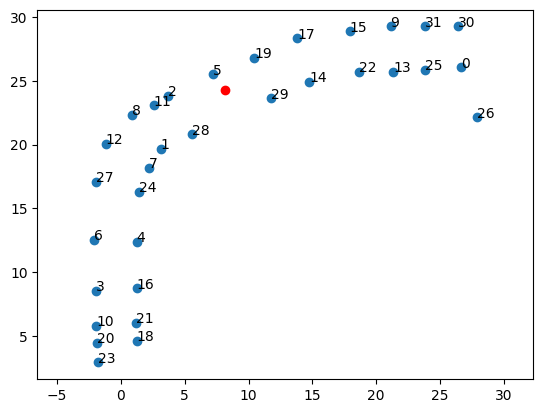

In [627]:

mask_keep = np.ones(len(cones_together), dtype=bool)
# mask_keep[1] = False

cones_together = cones_together[mask_keep]
plt.plot(*cones_together.T, "o")
plt.plot(*position, "ro")
for i, (x,y) in enumerate(cones_together):
    plt.text(x, y, str(i))

plt.axis("equal")

(-19.319936987861432, 20.55653666481439, -16.56656311001516, 2.390616044342194)

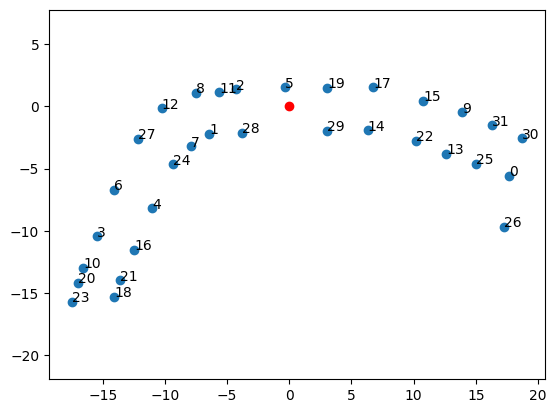

In [628]:
cones_relative = rotate(cones_together - position, -angle_from_2d_vector(direction))

plt.plot(*cones_relative.T, "o")
plt.plot(0, 0, "ro")
for i, (x,y) in enumerate(cones_relative):
    plt.text(x, y, str(i))
plt.axis("equal")

In [629]:
from fsd_path_planning.sorting_cones.trace_sorter.core_trace_sorter import TraceSorter
from fsd_path_planning.utils.cone_types import ConeTypes

In [662]:
ts_kwargs = dict(
    max_n_neighbors=5, max_dist=5.0, max_dist_to_first=6.0, max_length=10, threshold_directional_angle=np.deg2rad(40), threshold_absolute_angle=np.deg2rad(55)
)

ts = TraceSorter(**ts_kwargs)

In [663]:
ts.select_first_two_starting_cones(position, direction, cones_together, ConeTypes.LEFT)

array([87])

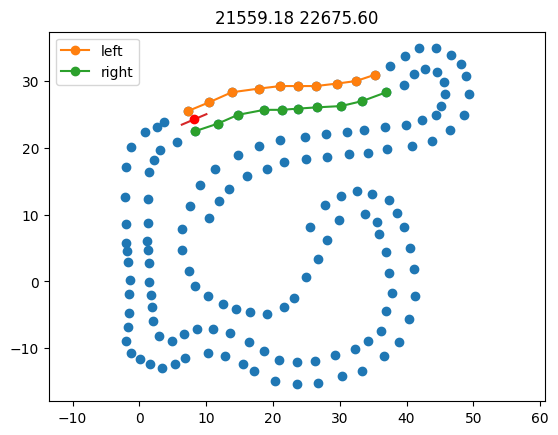

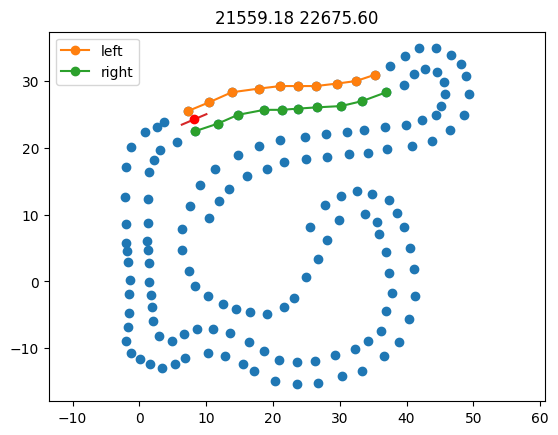

In [664]:
from fsd_path_planning.sorting_cones.trace_sorter.cost_function import cost_configurations


sort_order = [[ConeTypes.LEFT, ConeTypes.RIGHT], [ConeTypes.RIGHT, ConeTypes.LEFT]]

results = []

for first, second in sort_order:
    points_first, indices_first = ts.sort(cones_together, first, position, direction)

    mask_is_not_in_first = np.ones(len(cones_together), dtype=bool)
    mask_is_not_in_first[indices_first] = False

    cones_together_for_second = cones_together[mask_is_not_in_first]

    points_second, indices_second = ts.sort(cones_together_for_second, second, position, direction)

    left_points, right_points = (points_first, points_second) if first == ConeTypes.LEFT else (points_second, points_first)

    cost_left = cost_configurations(left_points, np.arange(len(left_points))[None], ConeTypes.LEFT, position, direction, return_individual_costs=False)
    cost_right = cost_configurations(right_points, np.arange(len(right_points))[None], ConeTypes.RIGHT, position, direction, return_individual_costs=False)


    car_start = position - direction * 2
    car_end = position + direction * 2
    car = np.array([car_start, car_end])

    plt.plot(*cones_together.T, "o")
    plt.plot(*left_points.T, "o-", label="left")
    plt.plot(*right_points.T, "o-", label="right")
    plt.title(f"{cost_left[0]:.2f} {cost_right[0]:.2f}")
    plt.plot(*car.T, "-")
    plt.plot(*position, "ro")
    plt.legend()
    plt.axis("equal")
    plt.show()


    results.append((left_points, right_points, position, direction))

    if len(left_points) > 3:
        results.append((left_points[:-1], right_points, position, direction))

    if len(right_points) > 3:
        results.append((left_points, right_points[:-1], position, direction))

# for r in results:
#     print(cost_configurations(*r, return_individual_costs=False))
    


In [665]:
from fsd_path_planning.sorting_cones.trace_sorter.line_segment_intersection import pairwise_segment_intersection, number_of_intersections
from fsd_path_planning.utils.math_utils import vec_angle_between
from scipy.spatial.distance import cdist

    
def intersection_cost(trace_left, trace_right):
    if len(trace_left) == 1 or len(trace_right) == 1:
        n = 0
    else:
        starts = np.row_stack([trace_left[:-1], trace_right[:-1]])
        ends = np.row_stack([trace_left[1:], trace_right[1:]])

        n_intersections_ignore = len(trace_left) - 2 + len(trace_right) - 2
        raw_intersections = pairwise_segment_intersection(starts, ends)

        n = number_of_intersections(raw_intersections) - n_intersections_ignore
    return n


def direction_of_turn_cost(trace: np.ndarray, cone_type: ConeTypes) -> float:
    # the left trace should not want to turn right and vice versa
    if cone_type == ConeTypes.LEFT:
        sign_of_bad_turn = -1
    elif cone_type == ConeTypes.RIGHT:
        sign_of_bad_turn = 1

    if len(trace) == 1:
        return 0
    
    d1 = np.diff(trace, axis=0)
    angles = np.arctan2(d1[:, 1], d1[:, 0])

    d2 = np.diff(angles)

    return np.abs(np.sum(d2 * (np.sign(d2) == sign_of_bad_turn)))

        


def combined_score_of_traces(trace_left: np.ndarray, trace_right: np.ndarray, position: np.ndarray, direction: np.ndarray):
    
    cost_left = cost_configurations(trace_left, np.arange(len(trace_left))[None], ConeTypes.LEFT, position, direction, return_individual_costs=False)[0]
    cost_right = cost_configurations(trace_right, np.arange(len(trace_right))[None], ConeTypes.RIGHT, position, direction, return_individual_costs=False)[0]

    n = intersection_cost(trace_left, trace_right)
    
    indivitual_cost, indivitual_cost_diff = individual_cost_metrics(cost_left, cost_right)

    left_turn_cost = direction_of_turn_cost(trace_left, ConeTypes.LEFT)
    right_turn_cost = direction_of_turn_cost(trace_right, ConeTypes.RIGHT)
    turn_cost = left_turn_cost + right_turn_cost


    weights = np.array([10000, 10, 1, 0])

    costs = np.array([n, indivitual_cost, indivitual_cost_diff, turn_cost])

    
    return (costs * weights).sum()

def individual_cost_metrics(cost_left, cost_right):
    if 0 in (cost_left, cost_right):
        indivitual_cost = max(cost_left, cost_right)
        indivitual_cost_diff = 0
    else:
        indivitual_cost = (cost_left + cost_right) / 2
        indivitual_cost_diff = abs(cost_left - cost_right)
    return indivitual_cost,indivitual_cost_diff




left_cones, right_cones, *_ = min(results, key=lambda x: combined_score_of_traces(*x))
    

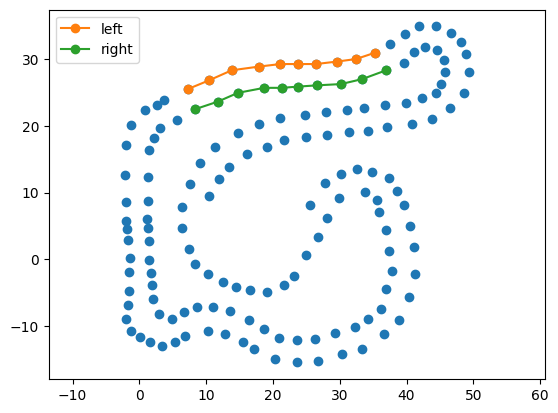

In [666]:
plt.plot(*cones_together.T, "o")
plt.plot(*left_cones.T, "o-", label="left")
plt.plot(*right_cones.T, "o-", label="right")
plt.axis("equal")
plt.legend()

In [667]:
from fsd_path_planning.utils.math_utils import normalize
from fsd_path_planning.sorting_cones.trace_sorter.line_segment_intersection import lines_segments_intersect_indicator
from typing import Optional


def find_first_intersection_in_trace(trace: np.ndarray, other_trace: np.ndarray) -> Optional[int]:
    for i in range(len(trace) - 1):
        for j in range(len(other_trace) - 1):
            start_1 = trace[i]
            end_1 = trace[i + 1]
            start_2 = other_trace[j]
            end_2 = other_trace[j + 1]

            if lines_segments_intersect_indicator(start_1, end_1, start_2, end_2):
                return i
        
    return None



def coloress_sorting(all_cones: np.ndarray, position: np.ndarray, direction: np.ndarray, is_final_run: bool=False) -> tuple[np.ndarray, np.ndarray]:
    """
    Sorts the cones into left and right cones. The first cone is always the left cone.
    :param all_cones: The cones to sort
    :param position: The position of the car
    :param direction: The direction of the car
    :return: The left and right cones
    """

    ts_kwargs_copy = ts_kwargs.copy()
    if is_final_run:
        ts_kwargs_copy["max_length"] = 10

    ts = TraceSorter(**ts_kwargs_copy)

    sort_order = [[ConeTypes.LEFT, ConeTypes.RIGHT], [ConeTypes.RIGHT, ConeTypes.LEFT]]

    results = []

    for first, second in sort_order:
        
        points_first, indices_first = ts.sort(all_cones, first, position, direction)

        mask_is_not_in_first = np.ones(len(all_cones), dtype=bool)
        mask_is_not_in_first[indices_first] = False

        cones_together_for_second = all_cones[mask_is_not_in_first]

        points_second, indices_second = ts.sort(cones_together_for_second, second, position, direction)

        left_points, right_points = (points_first, points_second)
        if first == ConeTypes.RIGHT:
            left_points, right_points = (points_second, points_first)
        

        results.append((left_points, right_points))

        if len(left_points) > 3:
            results.append((left_points[:-1], right_points))
        if len(right_points) > 3:
            results.append((left_points, right_points[:-1]))

  
    left_cones, right_cones = min(results, key=lambda x: combined_score_of_traces(*x, position=position, direction=direction))

    left_stop = find_first_intersection_in_trace(left_cones, right_cones)
    right_stop = find_first_intersection_in_trace(right_cones, left_cones)
    if left_stop is not None:
        left_cones = left_cones[:left_stop + 1]
    if right_stop is not None:
        right_cones = right_cones[:right_stop+1]

    # if not is_final_run and len(left_cones) > 1 and len(right_cones) > 1:
    #     return coloress_sorting(np.row_stack([left_cones, right_cones]), position, direction, is_final_run=True)
    
    
    
    return left_cones, right_cones

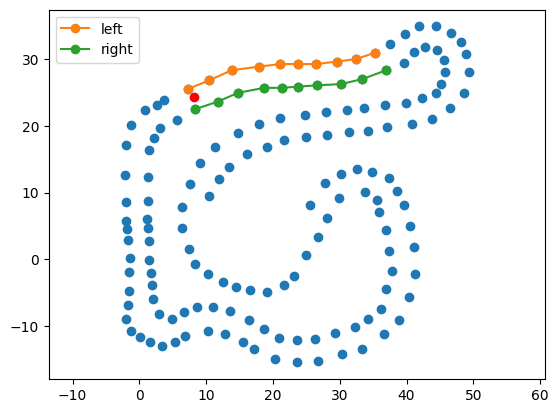

In [668]:


left_cones, right_cones = coloress_sorting(cones_together, position, direction)

plt.plot(*cones_together.T, "o")
plt.plot(*position, "ro")
plt.plot(*left_cones.T, "o-", label="left")
plt.plot(*right_cones.T, "o-", label="right")
plt.axis("equal")
plt.legend()

In [669]:
from fsd_path_planning.demo.json_demo import load_data_json
from tqdm import tqdm

demo_positions, demo_directions, demo_cones = load_data_json(Path('/home/papalotis/repos/fsd-path-planning/fsd_path_planning/demo/fss_19_4_laps.json'))
# demo_positions, demo_directions, demo_cones = load_data_json()

it = list(enumerate(zip(demo_positions, demo_directions, demo_cones)))

last_direction = None

for i, (demo_positions_i, demo_directions_i, demo_cones_i) in tqdm(it[:800]):
    if last_direction is not None:
        grad = demo_directions_i - last_direction
    else:
        grad = np.zeros_like(demo_directions_i)

    direction_to_use = normalize(demo_directions_i + grad * 0.2)


    demo_cones_i = [np.array(cones_of_type).reshape(-1,2) for cones_of_type in demo_cones_i]
    cones_together = np.row_stack(demo_cones_i)

    left_cones, right_cones = coloress_sorting(cones_together, demo_positions_i, demo_directions_i)

    last_direction = demo_directions_i

    plt.plot(*cones_together.T, "o")
    plt.plot(*demo_positions_i, "ro")
    plt.plot(*left_cones.T, "o-", label="left")
    plt.plot(*right_cones.T, "o-", label="right")
    plt.axis("equal")
    plt.title(f"{i}")
    plt.savefig(f"frames/frame_{i:04d}.png")
    plt.close()
    # plt.show()

100%|██████████| 800/800 [04:23<00:00,  3.03it/s]


63


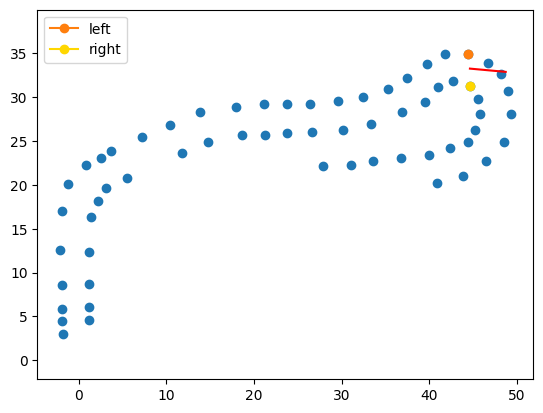

In [659]:
from fsd_path_planning.utils.math_utils import normalize

# important indices: 96, 70, 74 328, 191, 118, 182, 355, 144, 168, 197, 362, 205
# import indices fss_19_4_laps.json: 170, 171, 319, 290, 306, 342

_, (pos, dir_, cones) = it[179]

pos_end = pos + normalize(dir_) * 4.1

all_cones = np.row_stack([np.array(c).reshape(-1,2) for c in cones])

print(len(all_cones))

left_cones, right_cones = coloress_sorting(all_cones, pos, dir_)

plt.plot(*all_cones.T, "o")
plt.plot([pos[0], pos_end[0]],[pos[1], pos_end[1]], "r-")

plt.plot(*left_cones.T, "o-", label="left")
plt.plot(*right_cones.T, "o-", label="right", color="gold")
plt.axis("equal")
plt.legend()

In [624]:
x = repr(it[91][1])
Path("test.txt").write_text(x)

1248